# Optimization Function

In [4]:
import logging
import pandas as pd
import os
import time
import oemof.solph as solph
import oemof.outputlib as outputlib
%matplotlib inline
from oemof.outputlib import processing, views
from oemof.solph import (Sink, Transformer, Source, Bus, Flow, NonConvex,
                         Model, EnergySystem, components, custom, Investment)
from oemof.solph.components import OffsetTransformer
from oemof.tools import logger, economics
from oemof.network import Node
import oemof.graph as grph
import matplotlib.pyplot as plt

In [5]:
def opti1gen(start, number_of_time_steps, n_gen, pv_price=1250, fuel_price1=0.3,fuel_price2=0.5):
    
    #Importing the solver
    solver = 'cbc' 
    debug = False  
    date_time_index = pd.date_range(start, periods=number_of_time_steps,
                                    freq='H')
    # Load the data, Demand is in kW

    filename ='dataoemofV4.csv'
    data = pd.read_csv(filename)
    data.set_index('date',inplace=True)
    first=date_time_index[0].strftime('%Y-%m-%d %H:%M:%S')
    last=date_time_index[-1].strftime('%Y-%m-%d %H:%M:%S')
    data=data[first: last]
    
    #Initialization of the energy system
    energysystem = solph.EnergySystem(timeindex=date_time_index)

    logging.info('Create oemof objects')

    # The bus objects were assigned to variables which makes it easier to connect
    # components to these buses (see below).

    # create electricity bus
    bel = solph.Bus(label="electricity")
    if n_gen ==1 :
        b_fuel_heavy = solph.Bus(label='diesel_source')
        energysystem.add(bel, b_fuel_heavy)
    if n_gen>1 :
        b_fuel_heavy = solph.Bus(label='diesel_source')
        b_fuel_light = solph.Bus(label='light_fuel_source')
        energysystem.add(bel, b_fuel_light,b_fuel_heavy)
        

    # adding the buses to the energy system
    

    # create excess component for the electricity bus to allow overproduction
    excess_bel = solph.Sink(label='excess_bel', inputs={bel: solph.Flow(variable_costs=0)} )

    # create source object representing the diesel generator commodity (annual limit)
    if n_gen>0 :
        diesel_heavy = solph.Source(label='diesel_light', 
                                    outputs={b_fuel_heavy: solph.Flow(variable_costs=fuel_price1)})
        energysystem.add(diesel_heavy)
    if n_gen>1 :
         diesel_light= solph.Source(label='diesel_heavy', 
                                    outputs={b_fuel_light: solph.Flow(variable_costs=fuel_price2)})
         energysystem.add(diesel_light)
    # create simple sink object representing the electrical demand
    demand = solph.Sink(label='demand', inputs={bel: solph.Flow(
        actual_value=data['demand_el'], fixed=True, nominal_value=1)})


    # create fixed source object representing pv power plants
    pv = solph.Source(label='pv',
                      outputs={bel: solph.Flow( actual_value=data['pv'],
                                                nominal_value=None,
                                                investment=solph.Investment(
                                                    ep_costs=(economics.annuity(
                                                        pv_price, 20, 0.094)/8760)*number_of_time_steps,
                                                    maximum=1000,
                                                    existing=0),
                                                fixed=True
                                                )})

    # create custom diesel (to make by ourselves)
    eta_min = 0.5       # efficiency at minimal operation point
    eta_max = 1       # efficiency at nominal operation point
    P_out_min_1 = 50      # absolute minimal output power
    P_out_max_1 = 150     # absolute nominal output power

    P_out_min_3 = 30      # absolute minimal output power
    P_out_max_3 = 100     # absolute nominal output power

    P_out_min_2 = 42      # absolute minimal output power
    P_out_max_2 = 140     # absolute nominal output power

    P_out_min_4 = 100  # absolute minimal output power
    P_out_max_4 = 300  # absolute nominal output power

    # calculate limits of input power flow
    P_in_min_1 = P_out_min_1 / eta_min
    P_in_max_1 = P_out_max_1 / eta_max

    P_in_min_2 = P_out_min_2 / eta_min
    P_in_max_2 = P_out_max_2 / eta_max

    P_in_min_3 = P_out_min_3 / eta_min
    P_in_max_3 = P_out_max_3 / eta_max

    P_in_min_4 = P_out_min_4 / eta_min
    P_in_max_4 = P_out_max_4 / eta_max


    # calculate coefficients of input-output line equation
    c11 = (P_out_max_1-P_out_min_1)/(P_in_max_1-P_in_min_1)
    c01 = P_out_max_1 - c11*P_in_max_1

    c12 = (P_out_max_2-P_out_min_2)/(P_in_max_2-P_in_min_2)
    c02 = P_out_max_2 - c12*P_in_max_2

    c13 = (P_out_max_3-P_out_min_3)/(P_in_max_3-P_in_min_3)
    c03 = P_out_max_3 - c13*P_in_max_3

    c14 = (P_out_max_4-P_out_min_4)/(P_in_max_4-P_in_min_4)
    c04 = P_out_max_4 - c14*P_in_max_4

    # define OffsetTransformer
    if n_gen > 0 :
        Diesel_Gen1 = solph.components.OffsetTransformer(
            label='Diesel_Gen1',
            inputs={b_fuel_heavy: solph.Flow(
                nominal_value=P_in_max_1,
                max=1,
                min=P_in_min_1/P_in_max_1,
                nonconvex=solph.NonConvex(startup_costs=1))},
            outputs={bel: solph.Flow(
                variable_costs=0.02)},
            coefficients = [c01, c11])
        energysystem.add(Diesel_Gen1)
    if n_gen > 1 :
        Diesel_Gen2 = solph.components.OffsetTransformer(
            label='Diesel_Gen2',
            inputs={b_fuel_light: solph.Flow(
                nominal_value=P_in_max_2,
                max=1,
                min=P_in_min_2/P_in_max_2,
                nonconvex=solph.NonConvex(startup_costs=1))},
            outputs={bel: solph.Flow(
                variable_costs=0.02)},
            coefficients = [c02, c12])
        energysystem.add(Diesel_Gen2)
    if n_gen > 2 :
        Diesel_Gen3 = solph.components.OffsetTransformer(
            label='Diesel_Gen3',
            inputs={b_fuel_heavy: solph.Flow(
                nominal_value=P_in_max_3,
                max=1,
                min=P_in_min_3/P_in_max_3,
                nonconvex=solph.NonConvex(startup_costs=1))},
            outputs={bel: solph.Flow(
                variable_costs=0.02)},
            coefficients = [c03, c13])
        energysystem.add(Diesel_Gen3)
    if n_gen > 3 :
        Diesel_Gen4 = solph.components.OffsetTransformer(
            label='Diesel_Gen4',
            inputs={b_fuel_heavy: solph.Flow(
                nominal_value=P_in_max_4,
                max=1,
                min=P_in_min_4 / P_in_max_4,
                nonconvex=solph.NonConvex(startup_costs=1))},
            outputs={bel: solph.Flow(
                variable_costs=0.02)},
            coefficients=[c04, c14])
        energysystem.add(Diesel_Gen4)
    
    energysystem.add(pv, excess_bel, demand)
    ##########################################################################
    # Optimise the energy system
    ##########################################################################

    logging.info('Optimise the energy system')

    # initialise the operational model
    om = solph.Model(energysystem)

    # if tee_switch is true solver messages will be displayed
    logging.info('Solve the optimization problem')
    om.solve(solver='cbc', solve_kwargs={'tee': False})

    ##########################################################################
    # Check and plot the results
    ##########################################################################

    # check if the new result object is working for custom components
    results = processing.results(om)

    #custom_storage = views.node(results, 'storage')
    electricity_bus = views.node(results, 'electricity')
    objective = outputlib.views.node(results, 'objective')
    meta_results = processing.meta_results(om)

    my_results = electricity_bus['scalars']

    # installed capacity of pv power plant in MW
    my_results['pv_invest_kW'] = (results[(pv, bel)]['scalars']['invest']/1e3)
    # generation of PV
    my_results['pv_gen'] = (results[(pv, bel)]['sequences'].sum())
    # generation of gas fired power plant in MWh
    electricity_result= electricity_bus['sequences']
    electricity_result.rename(columns={electricity_result.columns[-3]:'Demand_el'}, inplace=True)
    electricity_result.rename(columns={electricity_result.columns[-2]:'Excess'}, inplace=True)
    electricity_result.rename(columns={electricity_result.columns[-1]:'Pv'}, inplace=True)
    if n_gen > 0:
        my_results['diesel_gen1'] = (results[(Diesel_Gen1, bel)]['sequences'].sum())
        my_results['res_share'] = (1 - results[(Diesel_Gen1, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum())
        electricity_result.rename(columns={electricity_result.columns[0]:'Generatrice_1'}, inplace=True)
        
    if n_gen > 1:
        my_results['diesel_gen2'] = (results[(Diesel_Gen2, bel)]['sequences'].sum())
        my_results['res_share'] = (1 - results[(Diesel_Gen1, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen2, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum())
        electricity_result.rename(columns={electricity_result.columns[1]:'Generatrice_2'}, inplace=True)
    if n_gen > 2:
        my_results['diesel_gen3'] = (results[(Diesel_Gen3, bel)]['sequences'].sum())
        my_results['res_share'] = (1 - results[(Diesel_Gen1, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen2, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen3, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum())
        electricity_result.rename(columns={electricity_result.columns[2]:'Generatrice_3'}, inplace=True)
    if n_gen > 3:
        my_results['diesel_gen4'] = (results[(Diesel_Gen4, bel)]['sequences'].sum())
        my_results['res_share'] = (1 - results[(Diesel_Gen1, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen2, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen3, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum() - results[(Diesel_Gen4, bel)]
                                    ['sequences'].sum()/results[(bel, demand)]
                                    ['sequences'].sum())
        electricity_result.rename(columns={electricity_result.columns[3]:'Generatrice_4'}, inplace=True)
        
    #excess energy, curtailment for overproduction
    my_results['excess'] = (results[(bel, excess_bel)]['sequences'].sum())
    # resulting renewable energy share

   
    #plot the time series (sequences) of a specific component/bus
    elecplot=electricity_result
    elecplot['Demand_el']=elecplot['Demand_el']* -1 
    elecplot['Excess']=elecplot['Excess'] * - 1 
    fig, ax = plt.subplots(figsize=(20, 18))
    elecplot.plot.area(ax=ax, fontsize=15)
    plt.ylabel('Power in kW', fontsize=25)
    plt.xlabel('Hours of the day',fontsize=25)
    fig.subplots_adjust(top=0.8)
    plt.show()
            
    #print(my_results)
    tc = om.objective()
    #print('tc :', tc)
    elec = electricity_bus
    return tc, elec, my_results


# Running the function

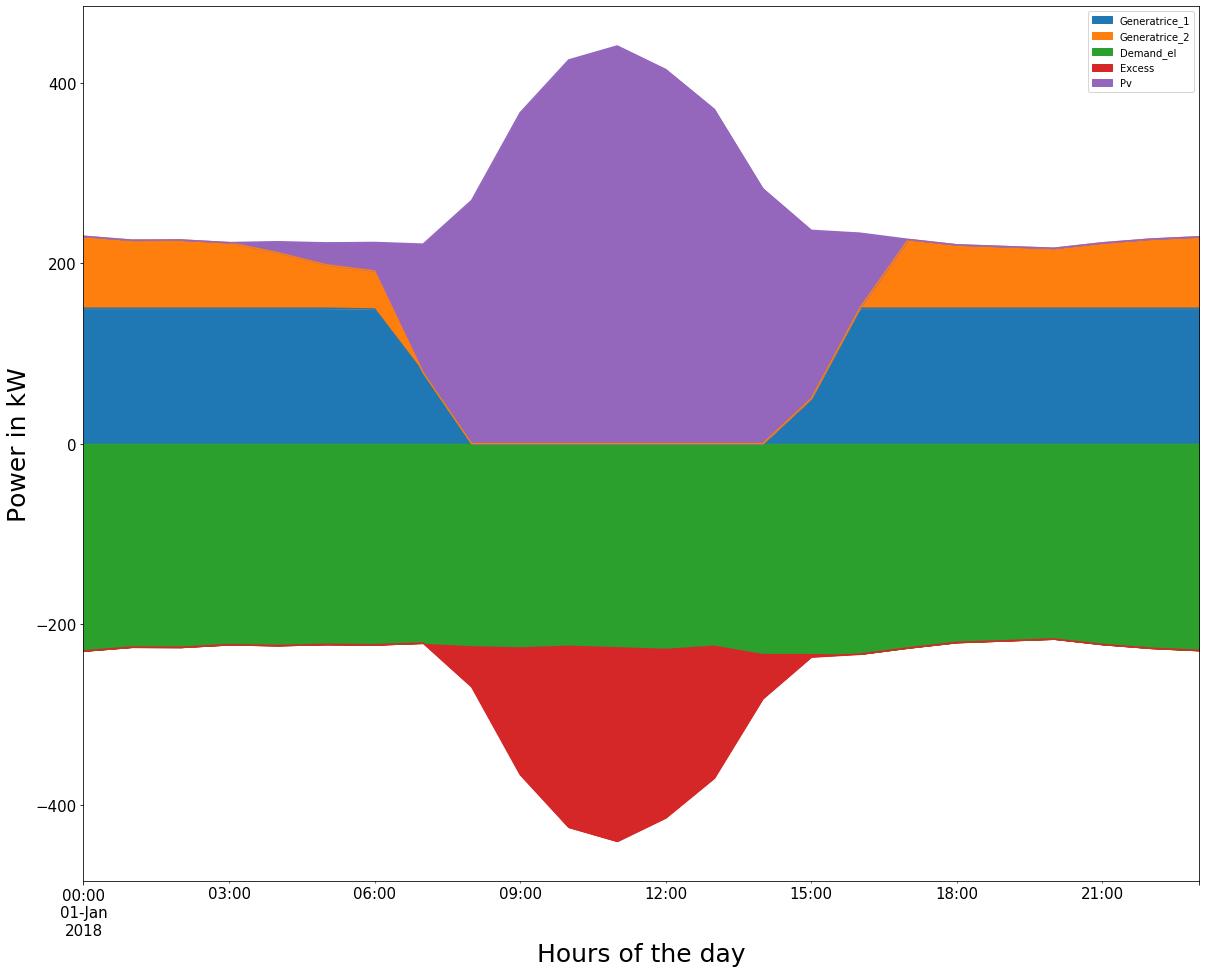

In [15]:
opt= opti1gen(start='2018-01-01', number_of_time_steps=24*1, n_gen=2, pv_price=1250, fuel_price1=0.3)

## Finding the best combination

In [17]:
def bestngen(ngenmin=1, ngenmax=5):
    ngenresult=[]
    for n_gen in range(ngenmin,ngenmax,1):
        opt = opti1gen(start='2018-01-01', number_of_time_steps=24*3, n_gen=n_gen, pv_price=1250, fuel_price1=0.3)
        ngenresult.append((n_gen, opt[0]))
    ngenresult=pd.DataFrame(ngenresult, columns=['n_gen', 'Total_cost'])
    fig, ax = plt.subplots()
    ngenresult.plot(x='n_gen', y='Total_cost', ax=ax)

    return ngenresult

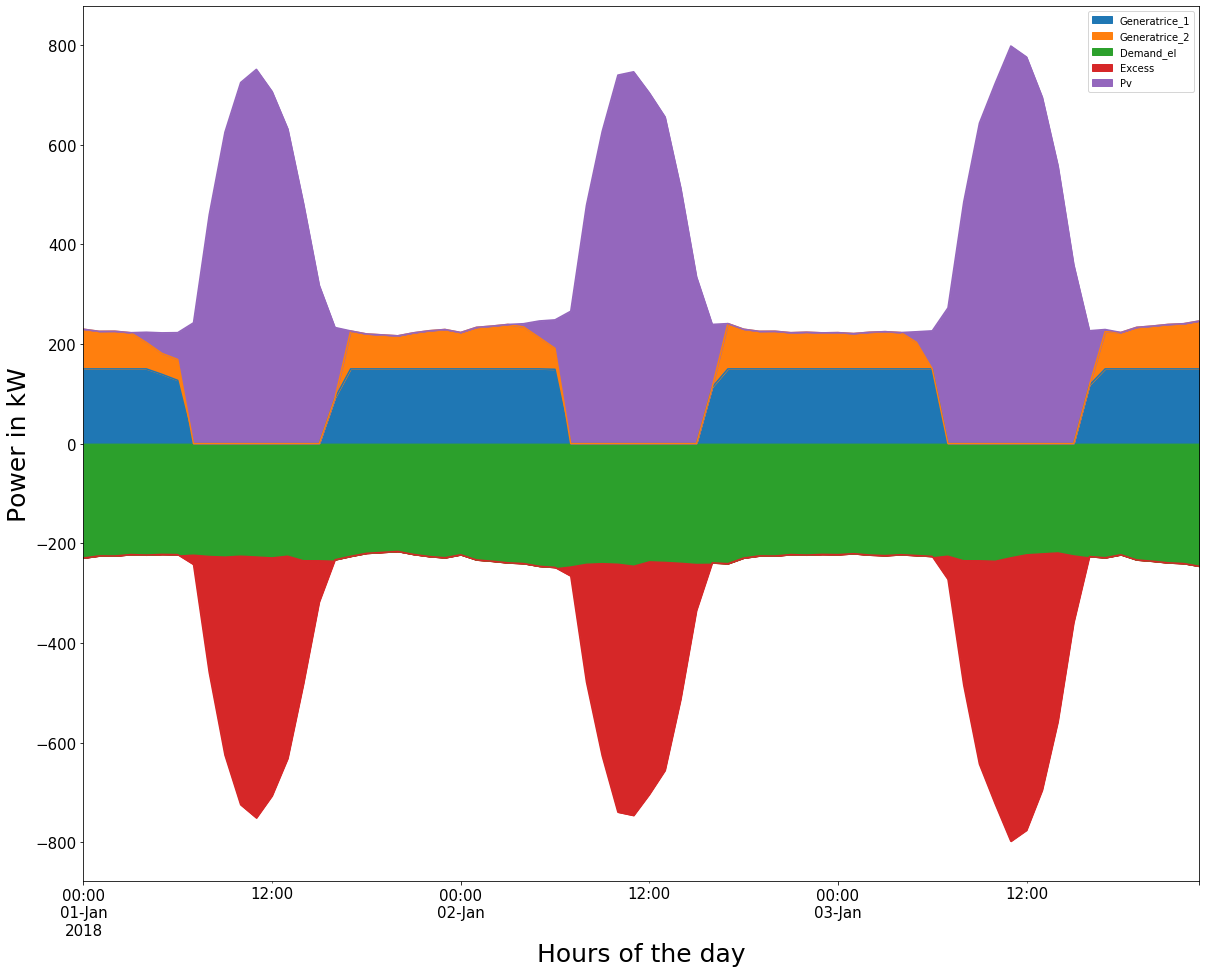

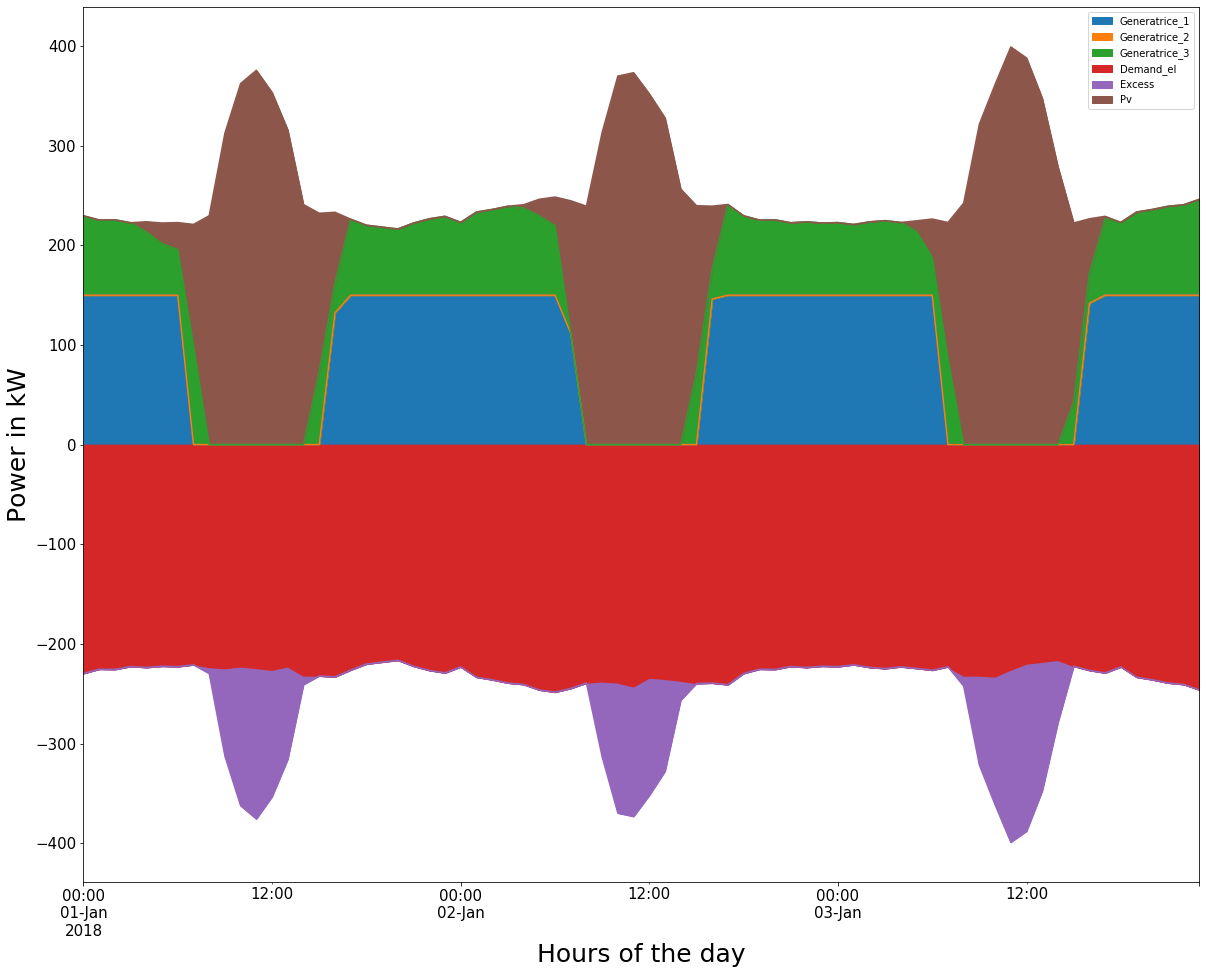

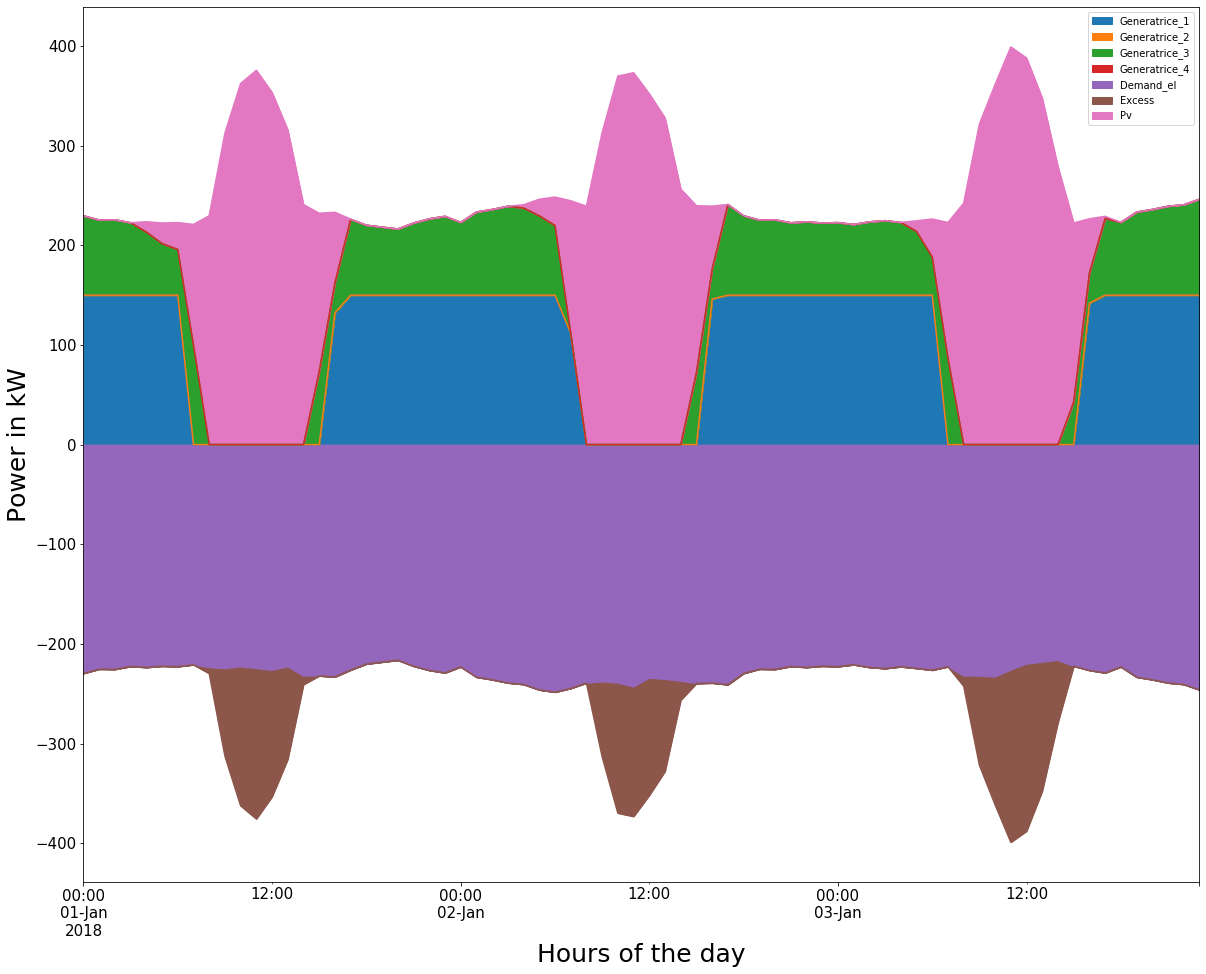

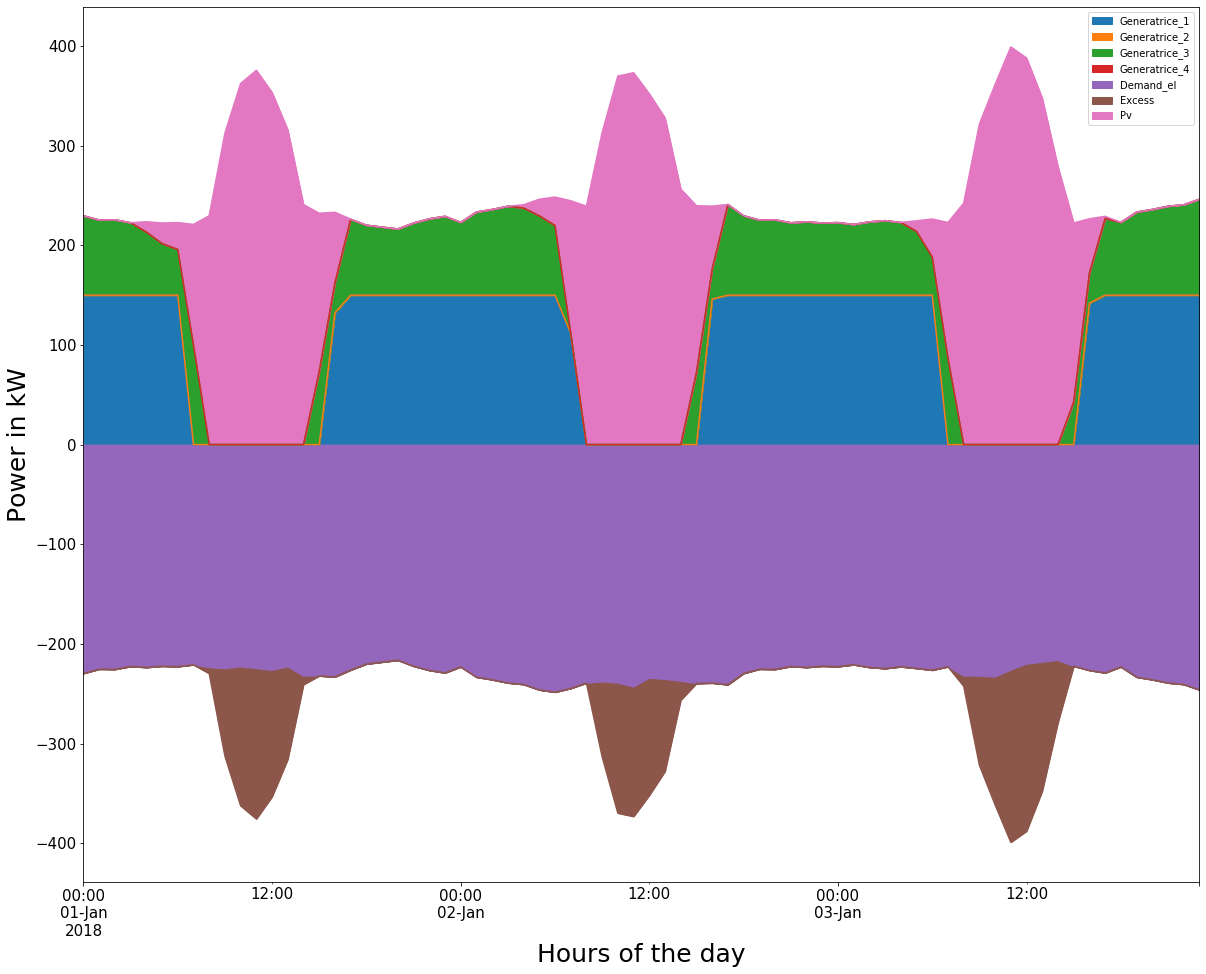

,n_gen,Total_cost
0,2,5431.985640
1,3,4107.273991
2,4,4107.273991
3,5,4107.273991


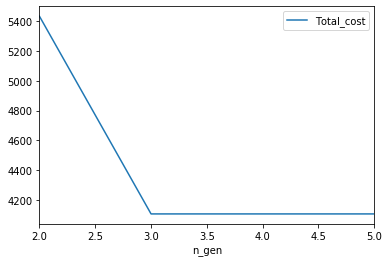

In [19]:
bestngen(ngenmin=2, ngenmax=6)